# Acoustic FWI using deepwave
- Marmousi model
- Local optimization

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

## FWI

### SGD

/home/utig5/shuhua/anaconda3_2023.9/envs/deepwave/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/disk/utig5/disk/fs4/shuhua/fwi/codes/fwi/cae_mcmc_fwi/deepwave/SVGD/fun_svgd.py:23: RuntimeWarning: invalid value encountered in multiply
  K = factor * (sqrt_2nu_d ** nu) * kv(nu, sqrt_2nu_d)


  0%|          | 0/200 [00:00<?, ?it/s]

/disk/utig5/disk/fs4/shuhua/fwi/codes/fwi/cae_mcmc_fwi/deepwave/SVGD/fun_svgd.py:23: RuntimeWarning: invalid value encountered in multiply
  K = factor * (sqrt_2nu_d ** nu) * kv(nu, sqrt_2nu_d)


Epoch 1/200,   Median Data Loss: 2.4343,  First Population Data Loss: 2.3935,  Kernel Bandwidth (h/nn).sqrt(): 2.0016,  Time: 111.57s
Epoch 2/200,   Median Data Loss: 2.0569,  First Population Data Loss: 2.0758,  Kernel Bandwidth (h/nn).sqrt(): 5.4683,  Time: 108.27s
Epoch 3/200,   Median Data Loss: 1.8039,  First Population Data Loss: 1.7490,  Kernel Bandwidth (h/nn).sqrt(): 7.3607,  Time: 108.87s
Epoch 4/200,   Median Data Loss: 1.6186,  First Population Data Loss: 1.5740,  Kernel Bandwidth (h/nn).sqrt(): 8.8023,  Time: 109.78s
Epoch 5/200,   Median Data Loss: 1.5086,  First Population Data Loss: 1.6163,  Kernel Bandwidth (h/nn).sqrt(): 9.9821,  Time: 112.31s
Epoch 6/200,   Median Data Loss: 1.4402,  First Population Data Loss: 1.6249,  Kernel Bandwidth (h/nn).sqrt(): 10.9936,  Time: 109.76s
Epoch 7/200,   Median Data Loss: 1.3945,  First Population Data Loss: 1.4729,  Kernel Bandwidth (h/nn).sqrt(): 11.8853,  Time: 110.20s
Epoch 8/200,   Median Data Loss: 1.3606,  First Population D

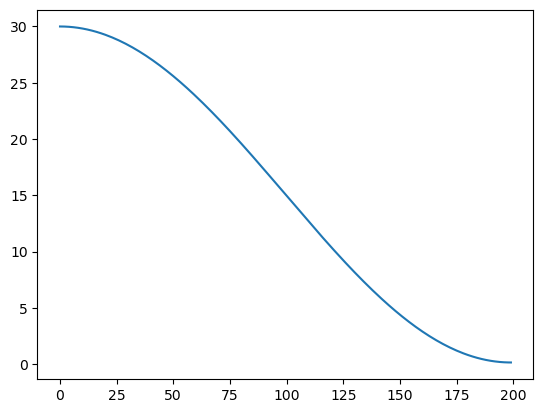

In [ ]:
import torch
from torchaudio.functional import biquad
from scipy.ndimage import gaussian_filter
from scipy.signal import butter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import numpy as np
from tqdm.auto import tqdm

import time


import sys
sys.path.append('/disk/utig5/disk/fs4/shuhua/fwi/codes/fwi/cae_mcmc_fwi/deepwave')
sys.path.append('/disk/utig5/disk/fs4/shuhua/fwi/codes/fwi/cae_mcmc_fwi/deepwave/SVGD')

import modifiedscalar
import fun_svgd as fsvgd



modeldir = "/disk/utig5/disk/fs4/shuhua/fwi/model/vp_marmousi_751_2301/"
workdir = "/disk/cg6/shuhua/deepwave/repara/"


water_vel=1700.0
water_n=5


device = torch.device('cuda' if torch.cuda.is_available()
                      else 'cpu')
ny = 2301
nx = 751
dx = 4.0
v_true = torch.from_file(modeldir + 'vp_marmousi_751_2301_4_2.dat',
                         size=ny*nx).reshape(ny, nx)

# v_true = v_true[0:ny:10, 0:nx:10]
# ny, nx = v_true.shape
dx = 25.0

ny = 128
nx = 64



nn = nx*ny
n_population = 512




vel_max=6000.0
vel_min=1500.0





v_true = torch.nn.functional.interpolate(v_true.unsqueeze(0).unsqueeze(0), size=[ny, nx], mode='nearest').squeeze().squeeze()
v_true[:, :water_n] = water_vel


single_v_shape = v_true.shape



# Smooth to use as starting model
v_init = (torch.tensor(1/gaussian_filter(1/v_true.numpy(), 3))
          .to(device))
v_init[:, :water_n] = water_vel




v_population = torch.zeros((n_population, nn), device=device)
for i in range(n_population):
    random_noise = torch.randn(v_init.shape, device=device) * 300
    random_noise[:, :water_n] = 0.0  # No noise in water layer
    random_noise[:, :] = 0.0
    v_population[i] = (v_init + random_noise).reshape(-1).clip(vel_min, vel_max)

matern_random_noise = fsvgd.generate_matern_2d_particles(
    num_pop=n_population,
    n1=ny, n2=nx,
    lengthscale_1=0.04, nu_1=1.5,
    lengthscale_2=0.04, nu_2=1.5, 
    output_std=144.0,
    seed=0,
    device=device,
)
matern_random_noise[:, :, :water_n] = 0.0  # No noise in water layer

v_population += matern_random_noise.reshape(n_population, -1).to(device)






initial_v_population_copy = v_population.clone().detach().cpu().reshape(n_population, *single_v_shape)



v_population = v_population.clone().detach()
v_population.requires_grad_()



v_grad_mask_poluation = fsvgd.f_water_mask_population(n_population, ny, nx, water_n).to(device)




with torch.no_grad():
    v_population.clamp_(vel_min, vel_max)







v = v_init.clone().detach()
v.requires_grad_()



grad_mask = torch.ones_like(v)
grad_mask[:, :water_n-1] = 0.0





n_shots = 15

n_sources_per_shot = 1
d_source = 9  # 10 * 25m = 250m
first_source = 1  # 1 * 25m = 25m
source_depth = 0  # 1 * 25m = 75m

n_receivers_per_shot = 128
d_receiver = 1  # 1 * 25m = 25m
first_receiver = 0  # 0 * 25m = 0m
receiver_depth = 0  # 1 * 25m = 25m

freq = 8.0
nt = 750
dt = 0.004
peak_time = 1.5 / freq



n_epochs = 200
output_interval = 1


# apply_diag_Hessian = True
apply_diag_Hessian = False


h_scaling = 0.1



scaling_diff_schedule = 30.0

diffusion_schedule = fsvgd.get_full_diffusion_schedule(num_iterations=n_epochs,
                                                 schedule_type = "cosine_annealing",
                                                  return_tensor=True)
diffusion_schedule = diffusion_schedule / diffusion_schedule.max() * scaling_diff_schedule
plt.plot(diffusion_schedule.numpy())





observed_data = (
    torch.from_file( workdir + 'marmousi_data.bin',
                    size=n_shots*n_receivers_per_shot*nt)
    .reshape(n_shots, n_receivers_per_shot, nt).to(device)
)

# Select portion of data for inversion
# n_shots = 20
# n_receivers_per_shot = 100
# nt = 300
# observed_data = (
#     observed_data[:n_shots, :n_receivers_per_shot, :nt].to(device)
# )

# source_locations
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = (torch.arange(n_shots) * d_source +
                             first_source)

# receiver_locations
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    (torch.arange(n_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(n_shots, 1)
)

# source_amplitudes
source_amplitudes = (
    (deepwave.wavelets.ricker(freq, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)


learning_rate = 5e1
optimiser_population = torch.optim.Adam( [v_population], lr=learning_rate)
# learning_rate = 1e8
# optimiser_population = torch.optim.SGD( [v_population], lr=learning_rate)


# optimisers = [
#     torch.optim.SGD([v], lr=1.2e6, momentum=0.0),
#     torch.optim.SGD([v], lr=1.2e6, momentum=0.9),
#     torch.optim.Adam([v], lr=5e1),
#     torch.optim.SGD([v], lr=2e6, momentum=0.0), # Add diagonal Hessian regularization/ Type 3
#     torch.optim.LBFGS([v], lr=10, line_search_fn='strong_wolfe'),
# ]

loss_fn = torch.nn.MSELoss()



population_loss_all = np.zeros((n_epochs+1, n_population))
median_loss_all = np.zeros(n_epochs+1)
h_all = np.zeros(n_epochs)

running_time = np.zeros(n_epochs)

for epoch in tqdm(range(n_epochs)):
    start_time = time.time()


    population_grad = []
    population_loss = []


    kernel_matrix, kernel_bandwidth = fsvgd.rbf_kernel(v_population, h_scaling=h_scaling)
    # print(f"Epoch {epoch+1}/{n_epochs} RBF Kernel h: {h:.4f}")





    for pop_id in range(n_population):

        v_single = v_population[pop_id].reshape(single_v_shape).detach().clone()
        v_single.requires_grad_()
            
        out = modifiedscalar.method2_scalar(
            v_single, dx, dt,
            source_amplitudes=source_amplitudes,
            source_locations=source_locations,
            receiver_locations=receiver_locations,
            pml_freq=freq,
            pml_width=[20, 20, 0, 20],
            max_vel = vel_max
        )

        loss = loss_fn(out[-1], observed_data)
        population_loss.append(loss.item())

        grad_single = torch.autograd.grad(
            loss, v_single,
        )

        # print(len(grad_single), grad_single[0].shape)


        # Apply gradient mask
        grad_single = [g * grad_mask for g in grad_single]

        if apply_diag_Hessian:
            diag_Hessian = out[-2].detach().clone()
            #Inverse of diag_Hessian
            diag_Hessian = 1.0/diag_Hessian
            # scaling of inverse diag_Hessian
            scl_H = torch.exp( torch.sum(torch.log(diag_Hessian)) / diag_Hessian.numel() )
            diag_Hessian /= scl_H

            # Apply diagonal Hessian
            grad_single = [g * diag_Hessian for g in grad_single]

        population_grad.append(grad_single[0].reshape(-1).detach().clone())
    

    population_grad = torch.stack(population_grad, dim=0)
    population_loss = np.array(population_loss)

    population_loss_all[epoch] = population_loss
    median_loss_all[epoch] = np.median(population_loss)
    h_all[epoch] = (kernel_bandwidth/2).sqrt().item()




    grad_K = -torch.matmul(kernel_matrix, v_population) + v_population * kernel_matrix.sum(dim=1, keepdim=True)
    phi = (torch.matmul(kernel_matrix, -population_grad) + grad_K) / n_population

    # Set the water layer velocity for phi
    phi = phi*v_grad_mask_poluation


    optimiser_population.zero_grad()
    # Assign gradient to population
    # v_population.grad = population_grad
    v_population.grad = -phi
    # Step
    optimiser_population.step()




    # Add noise

    with torch.no_grad():
        matern_random_noise_diffusion = fsvgd.generate_matern_2d_particles(
            num_pop=n_population,
            n1=ny, n2=nx,
            lengthscale_1=0.04, nu_1=1.5,
            lengthscale_2=0.04, nu_2=1.5, 
            output_std=1.0,
            device=device,
        ) * diffusion_schedule[epoch]
        matern_random_noise_diffusion[:, :, :water_n] = 0.0  # No noise in water layer
        noise = matern_random_noise_diffusion.reshape(n_population, -1).to(device)

        v_population.add_(noise)


    # Clamp the population velocities to the desired range
    with torch.no_grad():
        v_population.clamp_(vel_min, vel_max)


    

    if epoch == n_epochs - 1:
        # Get final population loss and median loss
        population_loss = []

        for pop_id in range(n_population):

            v_single = v_population[pop_id].reshape(single_v_shape).detach().clone()
            v_single.requires_grad_()
                
            out = modifiedscalar.method2_scalar(
                v_single, dx, dt,
                source_amplitudes=source_amplitudes,
                source_locations=source_locations,
                receiver_locations=receiver_locations,
                pml_freq=freq,
                pml_width=[20, 20, 0, 20],
                max_vel = vel_max
            )

            loss = loss_fn(out[-1], observed_data)
            population_loss.append(loss.item())
        population_loss = np.array(population_loss)

        population_loss_all[epoch+1] = population_loss
        median_loss_all[epoch+1] = np.median(population_loss)
    



    running_time[epoch] = time.time() - start_time

    if (epoch + 1) % output_interval == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, ",
            f" Median Data Loss: {median_loss_all[epoch]:.4f},",
            f" First Population Data Loss: {population_loss[0]:.4f},",
            f" Kernel Bandwidth (h/nn).sqrt(): {(kernel_bandwidth/nn).sqrt():.4f},",
            f" Time: {running_time[epoch]:.2f}s")
        

        # print(f"Calculated RBF kernel bandwidth sqrt(h): {h.sqrt():.4f}")



In [3]:
inverted_mean = v_population.mean(dim=0).reshape(single_v_shape).detach().clone().cpu()
inverted_std = v_population.std(dim=0).reshape(single_v_shape).detach().clone().cpu()
inverted_population_all = v_population.reshape(n_population, *single_v_shape).detach().clone().cpu()

#### Loss plot

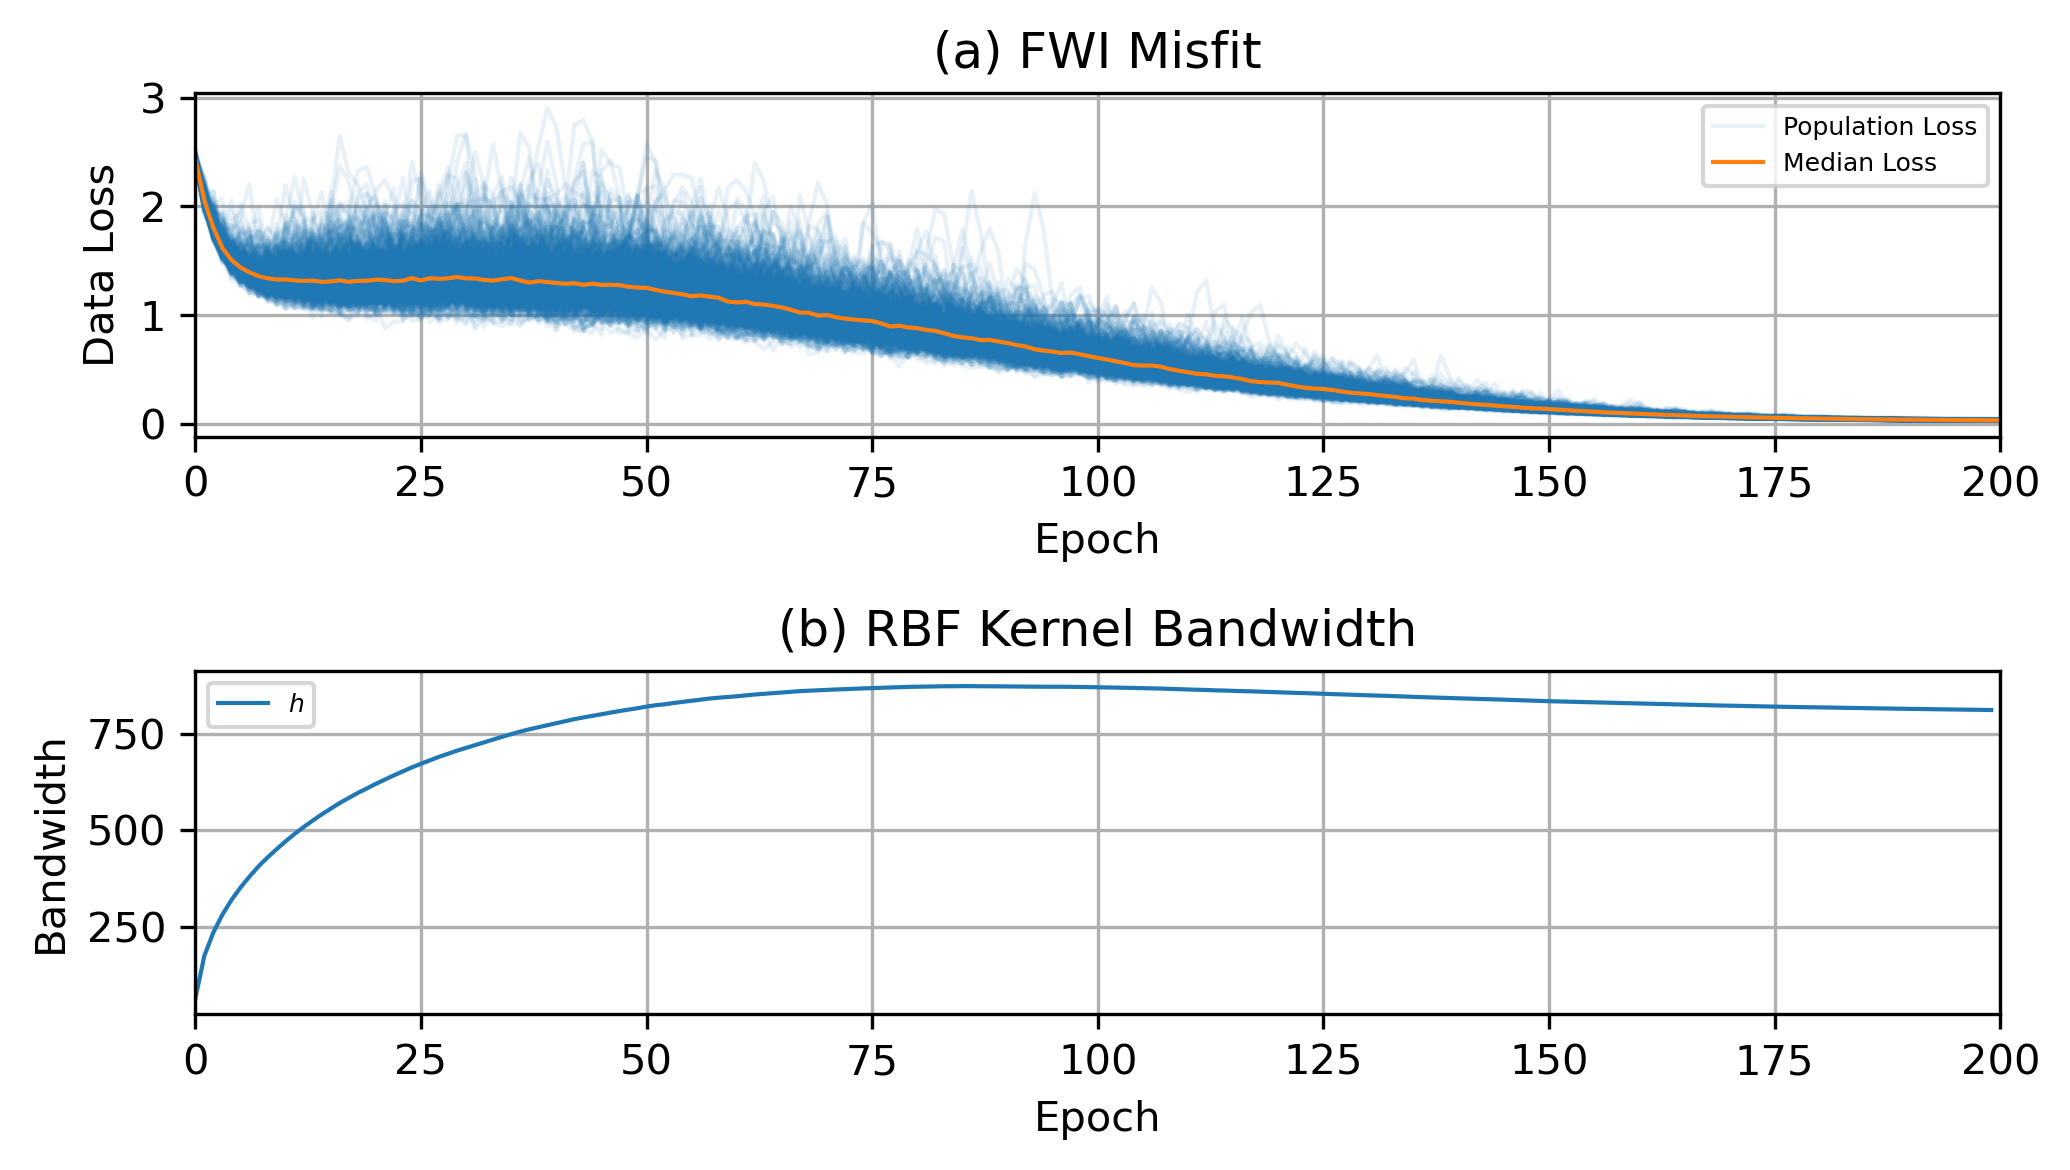

In [4]:
# losses = losses/losses[0]

plt.figure( figsize=(7, 4), dpi=300)

plt.subplot(2, 1, 1)

for i in range(n_population):
    if i == 0:
        label = "Population Loss"
    else:
        label = None
    plt.plot(population_loss_all[:, i], label=label, alpha=0.1, color='C0', linewidth=1.0)


plt.plot(median_loss_all, label="Median Loss", color='C1', linewidth=1.0)


plt.xlabel("Epoch")
plt.ylabel("Data Loss")
plt.xlim(0, n_epochs)
plt.legend(fontsize=6)
plt.grid()
# plt.yscale('log')
plt.title("(a) FWI Misfit")



plt.subplot(2, 1, 2)
plt.plot( h_all/2.0 , label="$h$", color='C0', linewidth=1.0)



plt.xlabel("Epoch")
plt.ylabel("Bandwidth")
plt.xlim(0, n_epochs)
plt.legend(fontsize=6)
plt.grid()
# plt.yscale('log')

plt.title("(b) RBF Kernel Bandwidth")




plt.tight_layout()

plt.show()


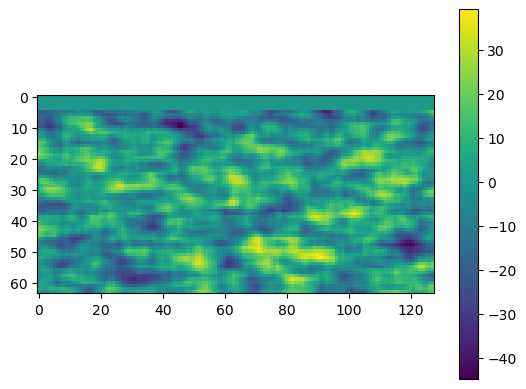

In [5]:
plt.imshow(matern_random_noise[0].cpu().numpy().T)
plt.colorbar()

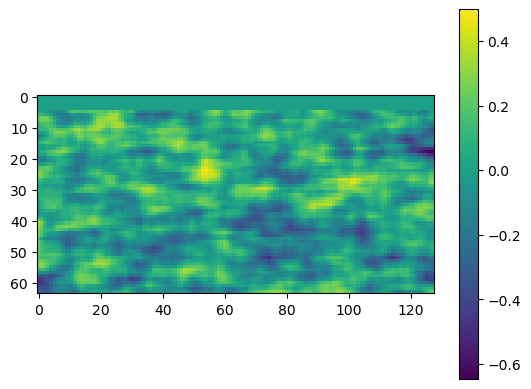

In [6]:
plt.imshow(matern_random_noise_diffusion[3].cpu().numpy().T)
plt.colorbar() 

#### Samples plot

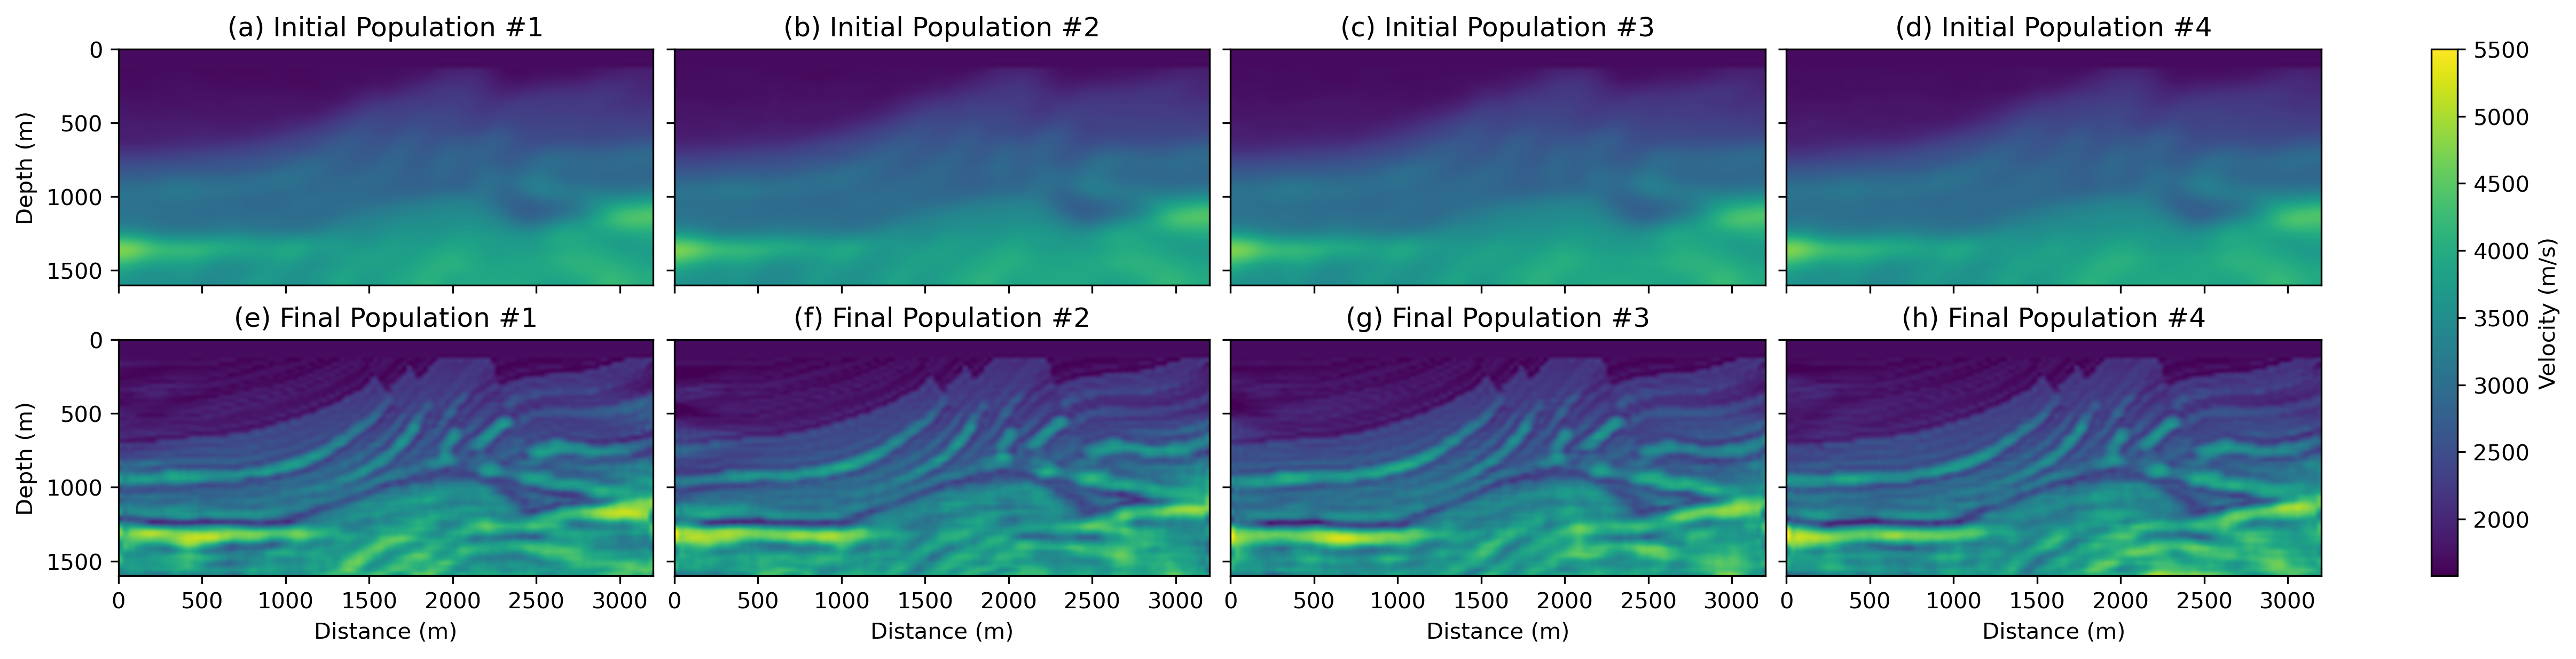

In [7]:

# Plot
vmin = v_true.min()
vmax = v_true.max()

std_min = inverted_std.min()
std_max = inverted_std.max()

fig, ax = plt.subplots(2, 4, figsize=(16, 4), sharex=True,
                     sharey=True, dpi=300, layout='compressed')










im0 = ax[0,0].imshow(initial_v_population_copy[0].T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
# ax[0,0].set_title("Initial Model")
ax[0,0].set_ylabel("Depth (m)")
# plt.colorbar(im0, ax=ax[0,0])
ax[0,0].set_title("(a) Initial Population #1")

im1 = ax[0,1].imshow(initial_v_population_copy[1].T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
#interpolation = 'nearest'
ax[0,1].set_title("(b) Initial Population #2")



im2 = ax[0,2].imshow(initial_v_population_copy[2].T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
#interpolation = 'nearest'
# mse = np.mean( (v_true.cpu().numpy() - inverted_mean.cpu().numpy())**2 )
ax[0,2].set_title("(c) Initial Population #3")



im3 = ax[0,3].imshow(initial_v_population_copy[3].T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
ax[0,3].set_title("(d) Initial Population #4")
# ax[0,3].set_xlabel("Distance (m)")
# ax[0,3].set_ylabel("Depth (m)")





im4 = ax[1,0].imshow(inverted_population_all[0].T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
# ax[1,0].set_title("Initial Model")
ax[1,0].set_ylabel("Depth (m)")
ax[1,0].set_xlabel("Distance (m)")
ax[1,0].set_title("(e) Final Population #1")

# plt.colorbar(im0, ax=ax[0,0])

im5 = ax[1,1].imshow(inverted_population_all[1].T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
#interpolation = 'nearest'
ax[1,1].set_title("(f) Final Population #2")
ax[1,1].set_xlabel("Distance (m)")


im6 = ax[1,2].imshow(inverted_population_all[2].T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
#interpolation = 'nearest'
# mse = np.mean( (v_true.cpu().numpy() - inverted_mean.cpu().numpy())**2 )
# ax[1,2].set_title("Inverted Mean "+f" MSE: {mse:.1e}")
ax[1,2].set_xlabel("Distance (m)")
ax[1,2].set_title("(g) Final Population #3")



im7 = ax[1,3].imshow(inverted_population_all[3].T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
# ax[1,3].set_title("Standard Deviation")
ax[1,3].set_xlabel("Distance (m)")
ax[1,3].set_title("(h) Final Population #4")
# ax[0,3].set_ylabel("Depth (m)")



plt.colorbar(im2, ax=ax, label="Velocity (m/s)")


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# fig.colorbar(im0, cax=cbar_ax, label="Velocity (m/s)")

# plt.tight_layout()
# plt.savefig(workdir + 'example_simple_fwi_local_optim.png')


#### Inversion results

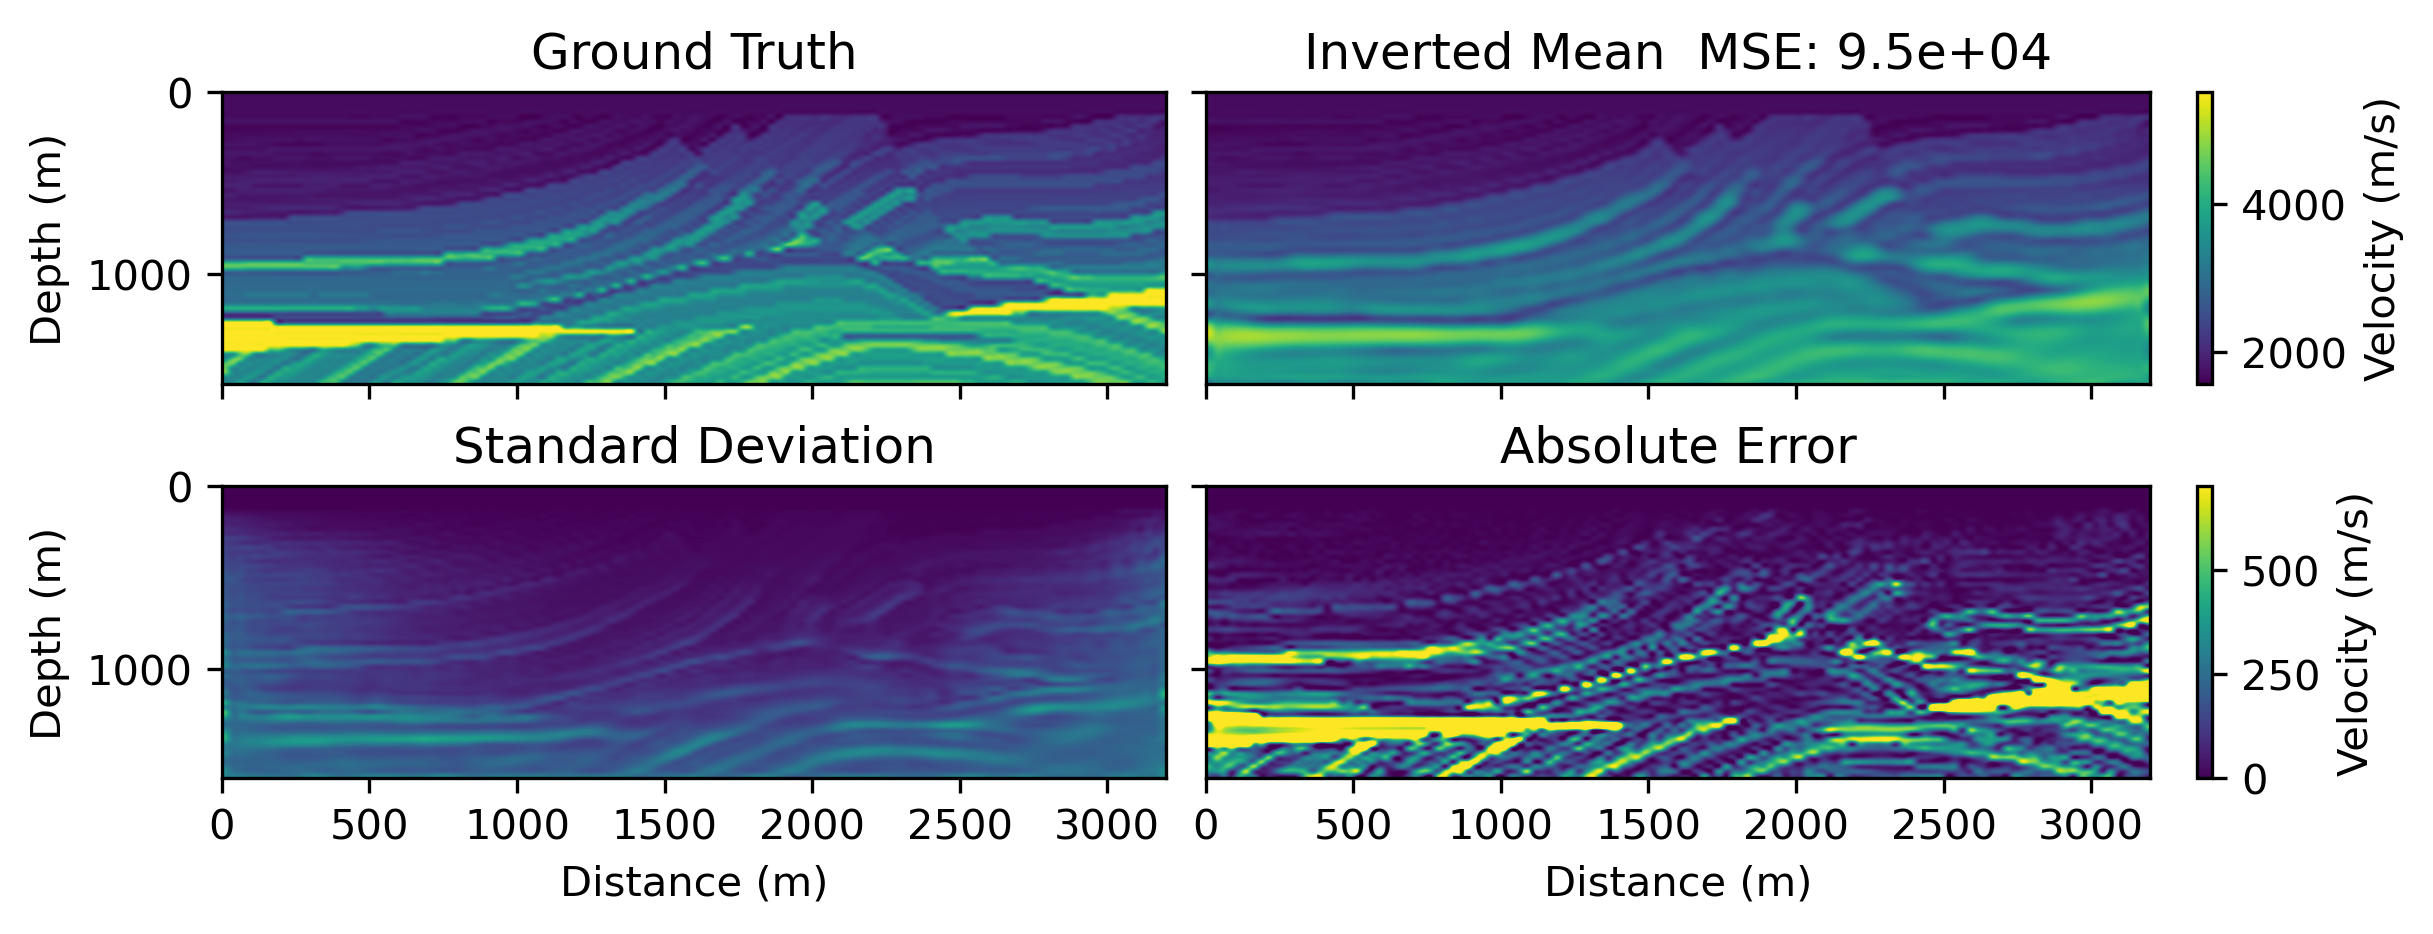

In [8]:

# Plot
vmin = v_true.min()
vmax = v_true.max()

# std_min = inverted_std.min() 
# std_max = inverted_std.max() * 0.6


std_min = 0.0 
std_max = 700


fig, ax = plt.subplots(2, 2, figsize=(8, 3), sharex=True,
                     sharey=True, dpi=300, layout='compressed')

im0 = ax[0,0].imshow(v_true.cpu().T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
ax[0,0].set_title("Ground Truth")
ax[0,0].set_ylabel("Depth (m)")
# plt.colorbar(im0, ax=ax[0,0])

# im2 = ax[0,1].imshow(inverted_mean.cpu().T, aspect='auto', cmap='viridis',
#              vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
# #interpolation = 'nearest'
# ax[0,1].set_title("Ground Truth")


im2 = ax[0,1].imshow(inverted_mean.T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
#interpolation = 'nearest'
mse = np.mean( (v_true.cpu().numpy() - inverted_mean.cpu().numpy())**2 )
ax[0,1].set_title("Inverted Mean "+f" MSE: {mse:.1e}")



im1 = ax[1,0].imshow(inverted_std.T, aspect='auto', cmap='viridis',
             vmin=std_min, vmax=std_max, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
ax[1,0].set_title("Standard Deviation")
ax[1,0].set_xlabel("Distance (m)")
ax[1,0].set_ylabel("Depth (m)")



im1 = ax[1,1].imshow( np.abs(v_true.cpu()-inverted_mean).T, aspect='auto', cmap='viridis',
             vmin=std_min, vmax=std_max, interpolation = 'spline36', extent=[0, ny*dx, nx*dx, 0])
ax[1,1].set_title("Absolute Error")
ax[1,1].set_xlabel("Distance (m)")
# ax[0,3].set_ylabel("Depth (m)")







cb1 = plt.colorbar(im2, ax=ax[0,1], label="Velocity (m/s)")
cb2 = plt.colorbar(im1, ax=ax[1,1], label="Velocity (m/s)")


# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# fig.colorbar(im0, cax=cbar_ax, label="Velocity (m/s)")

# plt.tight_layout()
# plt.savefig(workdir + 'example_simple_fwi_local_optim.png')


#### Inversion - Trace plot

NameError: name 'inverted_models' is not defined

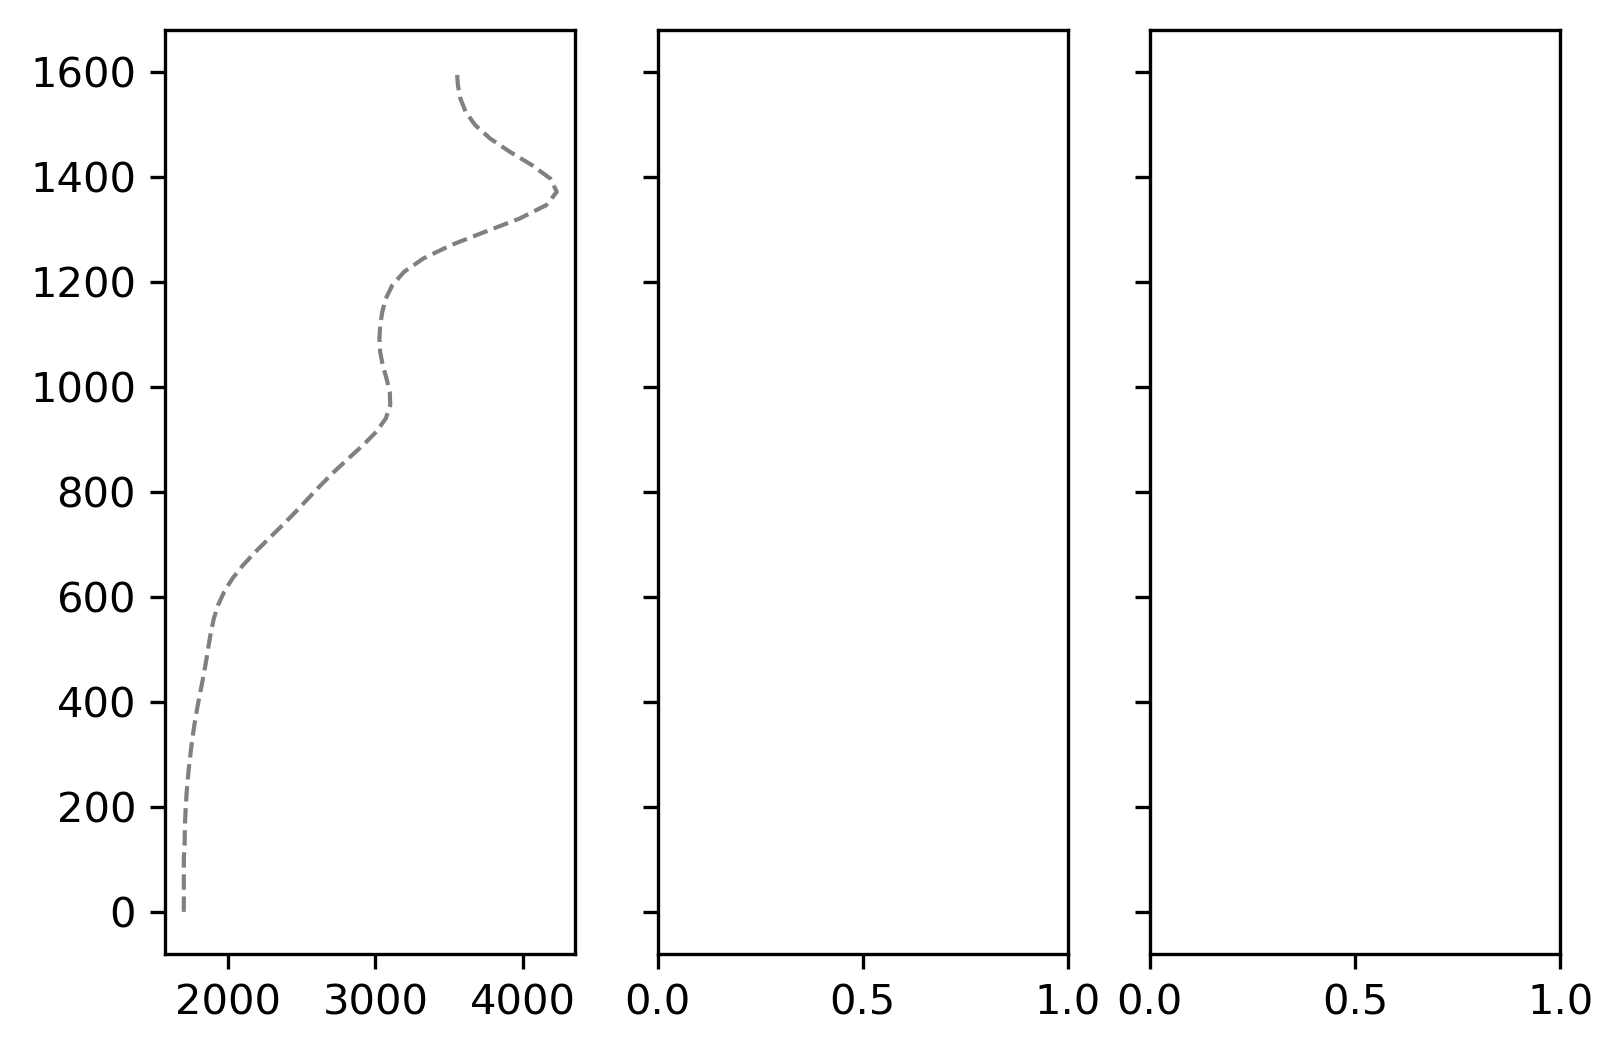

In [9]:
import matplotlib as mpl
n_lines = 5
cmap = mpl.colormaps['viridis_r']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))


locids = [10, 64, 118]
# locids = np.random.randint(0, ny, 3)
locids = np.sort(locids)
depth_4plot = np.linspace(0, nx*dx, nx)
lw = 1.0

fig, axes = plt.subplots(1, len(locids), figsize=(6, 4), dpi=300, sharey=True)

for ax, locid in zip(axes, locids):
    ax.plot(v_init.cpu()[locid], depth_4plot, lw=lw, ls='--', color="gray")
    ax.plot(inverted_models[0][locid], depth_4plot, lw=lw, alpha=0.9, ls='-',color=colors[0]) #GD
    ax.plot(inverted_models[3][locid], depth_4plot, lw=lw, alpha=0.9, ls='-',color=colors[1]) #GD with diag-Hessian
    ax.plot(inverted_models[1][locid], depth_4plot, lw=lw, alpha=0.9, ls='-',color=colors[2]) #GD with momentum
    ax.plot(inverted_models[2][locid], depth_4plot, lw=lw, alpha=0.9, ls='-',color=colors[3]) #ADAM
    ax.plot(inverted_models[4][locid], depth_4plot, lw=lw, alpha=0.9, ls='-',color=colors[4]) #LBFGS
    ax.plot(v_true.cpu()[locid], depth_4plot, lw=lw, ls='-', alpha=0.6, color="magenta")
    ax.set_title(f'x={locid*dx}m')
    ax.set_xlabel("Velocity (m/s)")
    ax.set_ylim(nx*dx, 0)
    ax.grid(lw=0.2, ls='--')

axes[0].set_ylabel("Depth (m)")
axes[2].legend(["Initial model", "Inverted \n(GD)", "Inverted \n(GD diag-Hessian)", "Inverted \n(GD Momentum)", "Inverted \n(ADAM)", "Inverted\n(LBFGS)", "True model"], loc='upper right', fontsize=6)


plt.tight_layout()
plt.show()

plt.savefig(workdir + 'MCMC_inversion_example_fwi_profiles.png')

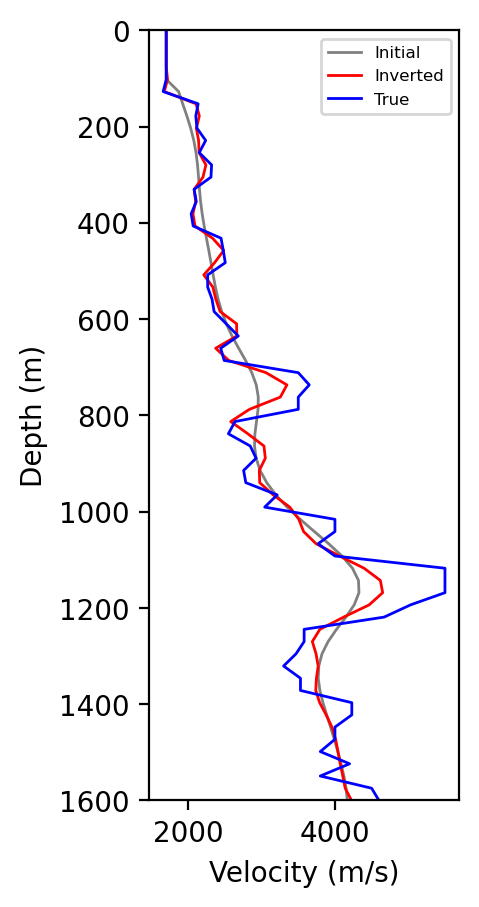

In [ ]:
depth_4plot = np.linspace(0, nx*dx, nx)
lw = 1.0
locid = 120


plt.figure(figsize=(2, 5), dpi=200)

plt.plot(v_init.cpu()[locid], depth_4plot, lw=lw, ls='-', color='gray')
plt.plot(v.detach().cpu()[locid], depth_4plot, lw=lw, ls='-', color='red')
plt.plot(v_true.cpu()[locid], depth_4plot, lw=lw, ls='-', color='blue')
plt.legend(["Initial", "Inverted", "True"], fontsize=6)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Depth (m)")
plt.ylim(nx*dx, 0)
plt.show()


### Multi-scale approach

* Multi-scale - Scipy -butterworth filter
* Velocity constriant
* l-BFGS

In [ ]:

## Second attempt: constrained velocity and frequency filtering


# Define a function to taper the ends of traces
def taper(x):
    return deepwave.common.cosine_taper_end(x, 100)


# Generate a velocity model constrained to be within a desired range
class Model(torch.nn.Module):
    def __init__(self, initial, min_vel, max_vel):
        super().__init__()
        self.min_vel = min_vel
        self.max_vel = max_vel
        self.model = torch.nn.Parameter(
            torch.logit((initial - min_vel) /
                        (max_vel - min_vel))
        )

    def forward(self):
        return (torch.sigmoid(self.model) *
                (self.max_vel - self.min_vel) +
                self.min_vel)


observed_data = taper(observed_data)
model = Model(v_init, 1500, 5500).to(device)




# Run optimisation/inversion
n_epochs = 5

for cutoff_freq in [3, 6, 9, 12, 15, 18, 21, 24]:
    print(f"Frequency: {cutoff_freq}")

    sos = butter(6, cutoff_freq, fs=1/dt, output='sos')
    sos = [torch.tensor(sosi).to(observed_data.dtype).to(device)
           for sosi in sos]

    def filt(x):
        return biquad(biquad(biquad(x, *sos[0]), *sos[1]), *sos[2])
    observed_data_filt = filt(observed_data)
    optimiser = torch.optim.LBFGS(model.parameters(),
                                  line_search_fn='strong_wolfe')
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        def closure():
            optimiser.zero_grad()
            v = model()
            out = scalar(
                v, dx, dt,
                source_amplitudes=source_amplitudes,
                source_locations=source_locations,
                receiver_locations=receiver_locations,
                max_vel=5500,
                pml_freq=freq,
                time_pad_frac=0.2,
                pml_width=[20, 20, 0, 20]
            )
            out_filt = filt(taper(out[-1]))
            loss = 1e6*loss_fn(out_filt, observed_data_filt)
            loss.backward()
            return loss

        optimiser.step(closure)
        print(f"Loss: {closure().item()}")


Frequency: 3
Epoch 1/5
Loss: 1.1220836639404297
Epoch 2/5
Loss: 0.5429150462150574
Epoch 3/5
Loss: 0.42493584752082825
Epoch 4/5
Loss: 0.37866178154945374
Epoch 5/5
Loss: 0.3609924018383026
Frequency: 6
Epoch 1/5
Loss: 44.99730682373047
Epoch 2/5
Loss: 20.280593872070312
Epoch 3/5
Loss: 10.789748191833496
Epoch 4/5
Loss: 6.730850696563721
Epoch 5/5
Loss: 4.506842136383057
Frequency: 9
Epoch 1/5
Loss: 158.8917694091797
Epoch 2/5
Loss: 88.2367172241211
Epoch 3/5
Loss: 59.24530792236328
Epoch 4/5
Loss: 43.1812858581543
Epoch 5/5
Loss: 31.72254180908203
Frequency: 12
Epoch 1/5
Loss: 393.0282287597656
Epoch 2/5
Loss: 223.67926025390625
Epoch 3/5
Loss: 129.09046936035156
Epoch 4/5
Loss: 85.9448013305664
Epoch 5/5
Loss: 61.54679489135742
Frequency: 15
Epoch 1/5
Loss: 326.93463134765625
Epoch 2/5
Loss: 196.02357482910156
Epoch 3/5
Loss: 123.76348876953125
Epoch 4/5
Loss: 88.14637756347656
Epoch 5/5
Loss: 69.4018783569336
Frequency: 18
Epoch 1/5
Loss: 223.40025329589844
Epoch 2/5
Loss: 158.6034

#### Inversion results

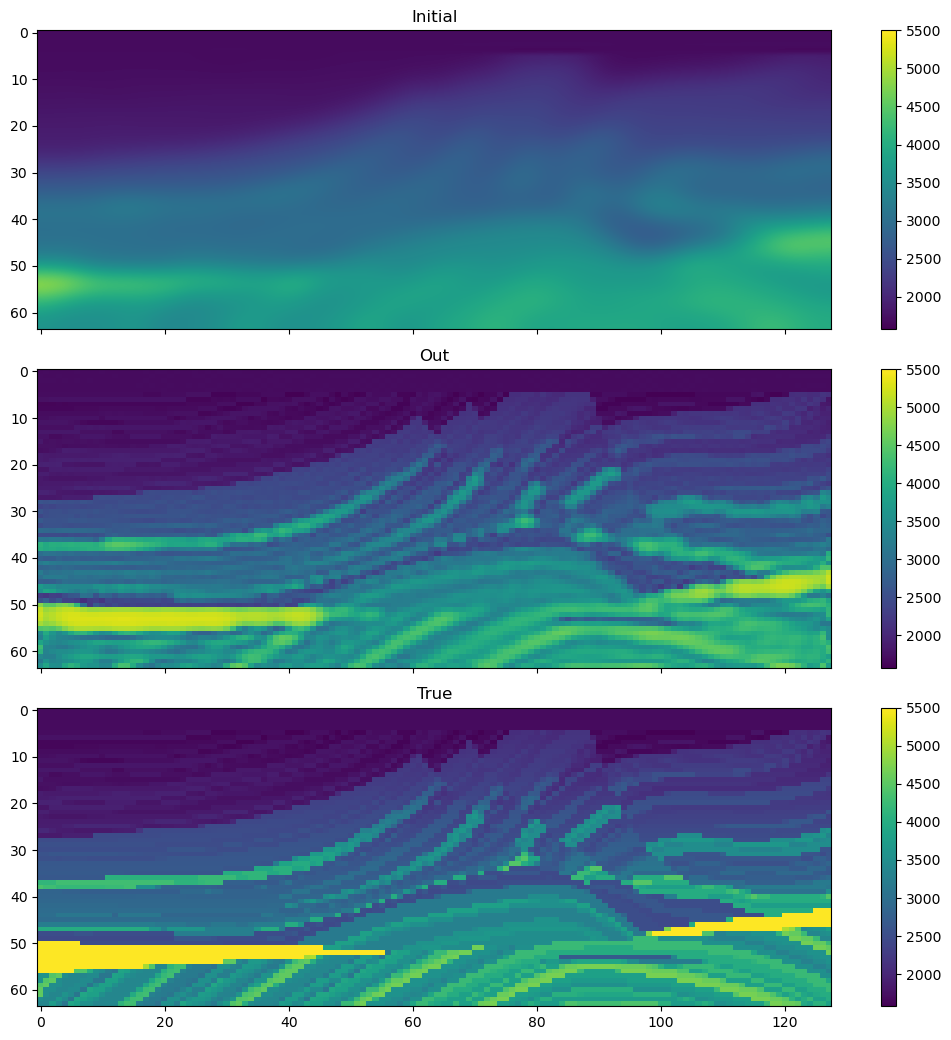

In [ ]:

v = model()
vmin = v_true.min()
vmax = v_true.max()
_, ax = plt.subplots(3, figsize=(10.5, 10.5), sharex=True,
                     sharey=True)
im1 = ax[0].imshow(v_init.cpu().T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'spline36')
ax[0].set_title("Initial")
plt.colorbar(im1)

im2 = ax[1].imshow(v.detach().cpu().T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'antialiased')
ax[1].set_title("Out")
plt.colorbar(im2)

im3 = ax[2].imshow(v_true.cpu().T, aspect='auto', cmap='viridis',
             vmin=vmin, vmax=vmax, interpolation = 'antialiased')
ax[2].set_title("True")
plt.colorbar(im3)



plt.tight_layout()
plt.savefig(workdir + 'example_increasing_freq_fwi_local_optim.png')

#### Inversion - Trace plot

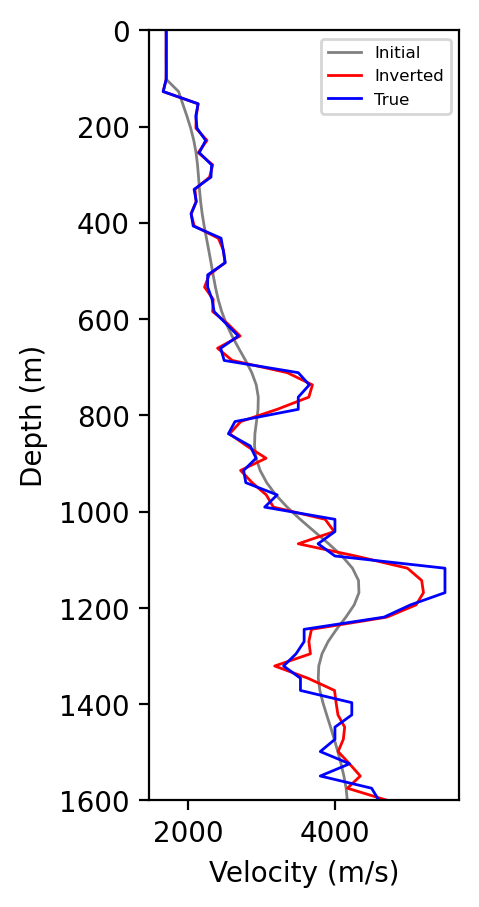

In [ ]:
depth_4plot = np.linspace(0, nx*dx, nx)
lw = 1.0
locid = 120


plt.figure(figsize=(2, 5), dpi=200)

plt.plot(v_init.cpu()[locid], depth_4plot, lw=lw, ls='-', color='gray')
plt.plot(v.detach().cpu()[locid], depth_4plot, lw=lw, ls='-', color='red')
plt.plot(v_true.cpu()[locid], depth_4plot, lw=lw, ls='-', color='blue')
plt.legend(["Initial", "Inverted", "True"], fontsize=6)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Depth (m)")
plt.ylim(nx*dx, 0)
plt.show()
